In [1]:
import os
from PIL import Image

def load_dataset(dataset_path):
    images = []
    labels = []
    
    # Get class names and clean them
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    classes = [name.replace('_dataset', '') for name in classes]  # Remove '_dataset' from names
    
    # Create class to index mapping
    class_to_idx = {name + '_dataset' if 'dataset' in orig_name else name: idx 
                   for idx, (name, orig_name) in enumerate(zip(classes, sorted([d for d in os.listdir(dataset_path) 
                   if os.path.isdir(os.path.join(dataset_path, d))])))}
    
    # Load images and labels
    for orig_class in os.listdir(dataset_path):
        if os.path.isdir(os.path.join(dataset_path, orig_class)):
            class_path = os.path.join(dataset_path, orig_class)
            class_idx = class_to_idx[orig_class]
            
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    img = Image.open(img_path).convert('RGB')
                    images.append(img)
                    labels.append(class_idx)
    
    return images, labels, classes

dataset_path = "/kaggle/input/neurodegenerative-diseases"
images, labels, classes = load_dataset(dataset_path)
print(f"Number of images loaded: {len(images)}")
print(f"Classes found: {classes}")

Number of images loaded: 7590
Classes found: ['alzheimers', 'normal', 'parkinsons']


In [2]:
def resize_images_to_minimally_divisible_by_8(images):
    resized_images = []
    for img in images:
        # Get original dimensions
        width, height = img.size
        
        # Calculate the new dimensions by reducing minimally to make them divisible by 8
        new_width = width - (width % 8)
        new_height = height - (height % 8)
        
        # Check if resizing is needed
        if width != new_width or height != new_height:
            print(f"Original size: {width}x{height} -> New size: {new_width}x{new_height}")
        
        # Crop the image to the new dimensions
        resized_img = img.crop((0, 0, new_width, new_height))
        resized_images.append(resized_img)
    
    return resized_images

# Resize all images to make their dimensions divisible by 8 and log changes
resized_images = resize_images_to_minimally_divisible_by_8(images)

# Check that all images are now divisible by 8
for idx, img in enumerate(resized_images):
    width, height = img.size
    assert width % 8 == 0 and height % 8 == 0, f"Image at index {idx} is not divisible by 8!"

print("All images resized to dimensions minimally divisible by 8.")


Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New size: 248x320
Original size: 364x448 -> New size: 360x448
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 250x320 -> New size: 248x320
Original size: 260x320 -> New size: 256x320
Original size: 260x320 -> New size: 256x320
Original size: 260x320 -> New size: 256x320
Original size: 250x320 -> New si

In [3]:
import torch
from torchvision import transforms

def normalize_and_convert_to_tensor(images):
    """
    Normalize and convert a list of PIL images to PyTorch tensors.
    """
    # Define the transformation: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Imagenet dataset.
    ])
    # Apply the transform to each image
    tensors = [transform(img) for img in images]
    return tensors

# Normalize and convert resized images to tensors
tensors = normalize_and_convert_to_tensor(resized_images)

# Log some details for verification
for i, tensor in enumerate(tensors[:5]):  # Print details of the first 5 tensors
    print(f"Image {i+1}: Shape = {tensor.shape}, Min = {torch.min(tensor):.3f}, Max = {torch.max(tensor):.3f}")

print(f"Total tensors created: {len(tensors)}")


Image 1: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.605
Image 2: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.466
Image 3: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.483
Image 4: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.588
Image 5: Shape = torch.Size([3, 128, 128]), Min = -2.118, Max = 2.518
Total tensors created: 7590


In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define your transforms here
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Split data into train, validation, and test sets (80:10:10)
train_images, test_images, train_labels, test_labels = train_test_split(
    resized_images, labels, test_size=0.2, random_state=42, stratify=labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Create datasets for each split
train_dataset = CustomImageDataset(images=train_images, labels=train_labels, transform=transform)
val_dataset = CustomImageDataset(images=val_images, labels=val_labels, transform=transform)
test_dataset = CustomImageDataset(images=test_images, labels=test_labels, transform=transform)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Checking DataLoader
for images, labels in train_loader:
    print(images.shape)  # Should print batch size and dimensions
    break


torch.Size([32, 3, 224, 224])


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load ResNet-101 with pretrained weights from ImageNet
model = models.resnet101(pretrained=True)

# Modify the final fully connected layer to output 3 classes (Alzheimer’s, Parkinson’s, Normal)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes


In [11]:
import torch.optim as optim
import torch.nn.functional as F

# Loss Function: CrossEntropyLoss (suitable for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam optimizer (can use other optimizers like SGD as well)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/10], Train Loss: 0.4534, Train Accuracy: 78.56%, Val Loss: 0.6150, Val Accuracy: 75.49%
Epoch [2/10], Train Loss: 0.3208, Train Accuracy: 85.01%, Val Loss: 0.3181, Val Accuracy: 87.22%
Epoch [3/10], Train Loss: 0.2676, Train Accuracy: 88.54%, Val Loss: 1.2861, Val Accuracy: 72.20%
Epoch [4/10], Train Loss: 0.2148, Train Accuracy: 90.55%, Val Loss: 0.6147, Val Accuracy: 76.55%
Epoch [5/10], Train Loss: 0.1573, Train Accuracy: 93.92%, Val Loss: 0.1489, Val Accuracy: 93.54%
Epoch [6/10], Train Loss: 0.1108, Train Accuracy: 95.54%, Val Loss: 0.1804, Val Accuracy: 92.49%
Epoch [7/10], Train Loss: 0.0881, Train Accuracy: 96.48%, Val Loss: 0.1245, Val Accuracy: 95.65%
Epoch [8/10], Train Loss: 0.0788, Train Accuracy: 97.32%, Val Loss: 0.2557, Val Accuracy: 92.09%
Epoch [9/10], Train Loss: 0.0511, Train Accuracy: 98.25%, Val Loss: 0.5141, Val Accuracy: 85.24%
Epoch [10/10], Train Loss: 0.0627, Train Accuracy: 97.66%, Val Loss: 0.4950, Val Accuracy: 86.17%


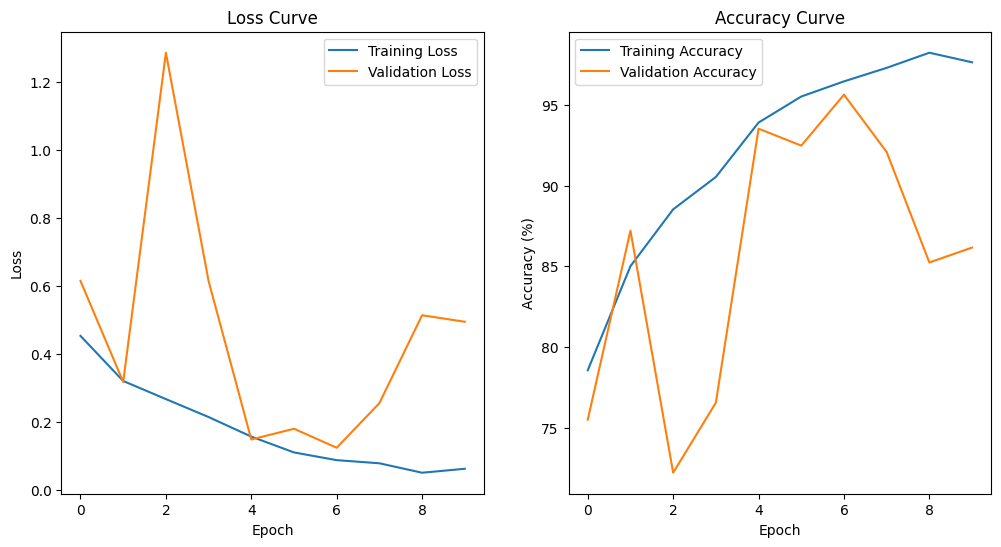

In [12]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn, optim

# Assuming the model, train_loader, and val_loader are already defined
# and that the dataset and transformations have been properly set up.

# Move the model to GPU
model = model.cuda()  # Ensure model is on GPU

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Lists to store loss and accuracy values during training and validation
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Number of epochs
num_epochs = 10

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move inputs and labels to GPU

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    # Average training loss and accuracy for the epoch
    train_losses.append(running_train_loss / len(train_loader))
    train_accuracy = 100 * correct_train_predictions / total_train_predictions
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Move inputs and labels to GPU

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val_predictions += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    # Average validation loss and accuracy for the epoch
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = 100 * correct_val_predictions / total_val_predictions
    val_accuracies.append(val_accuracy)

    # Print the loss and accuracy for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

# Plot the loss curves for both training and validation
plt.figure(figsize=(12, 6))

# Plotting the loss curve
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [13]:
# Evaluate on the test set
model.eval()  # Set to evaluation mode

test_accuracy = 0
test_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy += correct
        test_loss += loss.item()

    test_accuracy = 100 * test_accuracy / len(test_loader.dataset)
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.4512, Test Accuracy: 86.56%
